In [ ]:
!pip3 install kornia # differentiable image processing for pytorch
!pip3 install advertorch #adversarial ML package

     |████████████████████████████████| 204kB 7.4MB/s 
     |████████████████████████████████| 5.7MB 4.2MB/s 
  Created wheel for advertorch: filename=advertorch-0.2.3-cp36-none-any.whl size=5696223 sha256=850ad60f8294b8d2f4ad6e19f2b2eba601f88c3164d0b288f8a7bab8ffd5a782
  Stored in directory: /root/.cache/pip/wheels/9b/53/6e/6b2509701b0da68443fa3d4499733f5455d6d583afa8c46676
Successfully built advertorch


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.utils import make_grid
from torchsummary import summary

from advertorch.attacks import GradientSignAttack,GradientAttack,LinfPGDAttack

import kornia
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(7*7*64, 200)
        self.relu3 = nn.ReLU(inplace=True)
        self.linear2 = nn.Linear(200, 10)

    def forward(self, x):
        out = self.maxpool1(self.relu1(self.conv1(x)))
        out = self.maxpool2(self.relu2(self.conv2(out)))
        out = out.view(out.size(0), -1)
        out = self.relu3(self.linear1(out))
        out = self.linear2(out)
        return out


In [ ]:
device = 'cuda'
batch_size =128
test_batch_size = 64
epochs = 15
learning_rate = 0.01
weight_decay =  5e-4

In [ ]:
train_dataset = datasets.MNIST(root='../data/',train=True, download=True, 
    transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='../data/', train=False, download=True, 
    transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=test_batch_size, shuffle=True)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...






/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [ ]:
model = LeNet5()
model.to(device)

LeNet5(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=3136, out_features=200, bias=True)
  (relu3): ReLU(inplace=True)
  (linear2): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
#define loss and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)

In [ ]:
#FOR LOOP EPOCHS
#train the model
import time
start_time = time.time()


#VARIABLES,TRACKERS
for i in range(epochs):

  for j,(X_train,y_train) in enumerate(train_loader):
    
    j+=1

    #TRAIN
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    y_pred = model(X_train)
    loss = criterion(y_pred,y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if j% 250== 0:
      print(f'epoch {i} : batch  {j} : loss {loss.item()}')
      
current_time = time.time()
print(f'the model took {(current_time-start_time)/60} minutes to train')

epoch 0 : batch  250 : loss 0.3583642542362213
epoch 1 : batch  250 : loss 0.13268469274044037
epoch 2 : batch  250 : loss 0.19597956538200378
epoch 3 : batch  250 : loss 0.06837697327136993
epoch 4 : batch  250 : loss 0.058169495314359665
epoch 5 : batch  250 : loss 0.06968041509389877
epoch 6 : batch  250 : loss 0.14671145379543304
epoch 7 : batch  250 : loss 0.08754327893257141
epoch 8 : batch  250 : loss 0.09280575066804886
epoch 9 : batch  250 : loss 0.3010314702987671
epoch 10 : batch  250 : loss 0.16090092062950134
epoch 11 : batch  250 : loss 0.05173176899552345
epoch 12 : batch  250 : loss 0.040281955152750015
epoch 13 : batch  250 : loss 0.144689679145813
epoch 14 : batch  250 : loss 0.1882222443819046
the model took 1.950305954615275 minutes to train


Test accuracy Basic: 9695/10000 =  96.950%


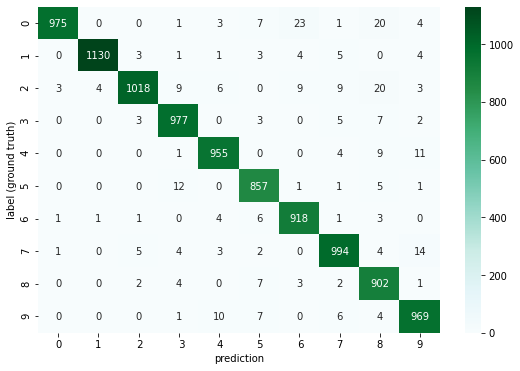

In [ ]:
#check test accuracy

test_load_all = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy Basic: {correct.item()}/{len(test_dataset)} = {correct.item()*100/(len(test_dataset)):7.3f}%')

class_names = ['0', '1', ' 2', '  3', ' 4', ' 5', ' 6', '7', '8', '9']
arr = confusion_matrix(predicted.view(-1).cpu(), y_test.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)


plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [ ]:
# this is an adversarial attack. peturbs input to classify stuff differently.

adversary = LinfPGDAttack(model,loss_fn=nn.CrossEntropyLoss(),eps=0.2,clip_min=0.0,clip_max=1.0,targeted=True)

In [ ]:
for X_test, y_test in test_load_all:
  X_test = X_test.to(device)
  break
target = (torch.ones_like(y_test)*2).to(device) #specify on which class to be classified as (2 here)
X_adv= adversary.perturb(X_test,target)  #carriees out attack.
print(X_adv.shape)

torch.Size([10000, 1, 28, 28])


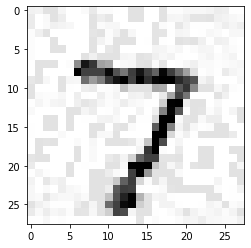

In [ ]:
plt.imshow(X_adv[0].cpu().detach().reshape(28,28),cmap="Greys") #first peturbed image

In [ ]:
img = X_adv[0].reshape(1,1,28,28)
cls = model(img)
predicted = torch.max(cls,1)[1]
print(f"Prediction on adversarial image is {predicted.item()}")

Prediction on adversarial image is 2


In [ ]:
gauss = kornia.filters.GaussianBlur2d((3,3), (10.5,10.5))  #blurs image
x_blur: torch.tensor = gauss(X_adv[0].reshape(1,1,28,28))

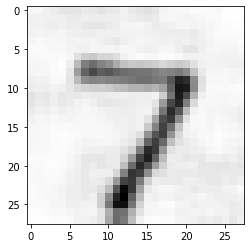

In [ ]:
plt.imshow(x_blur.reshape(28,28).cpu(),cmap="Greys") #image shown here

Test accuracy Basic: 1164/10000 =  11.640%


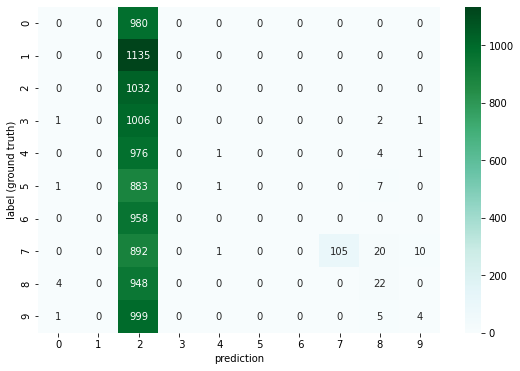

In [ ]:
test_load_all = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False)


correct = 0
for X_test, y_test in test_load_all:
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    adversary = LinfPGDAttack(model,loss_fn=nn.CrossEntropyLoss(),eps=0.2,clip_min=0.0,clip_max=1.0,targeted=True) ##
    target = (torch.ones_like(y_test)*2).to(device)   
    X_adv= adversary.perturb(X_test,target)  #@@@
    y_val = model(X_adv)
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test).sum()
        
print(f'Test accuracy Basic: {correct.item()}/{len(test_dataset)} = {correct.item()*100/(len(test_dataset)):7.3f}%')

class_names = ['0', '1', ' 2', '  3', ' 4', ' 5', ' 6', '7', '8', '9']
arr = confusion_matrix(y_test.view(-1).cpu(), predicted.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)


plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

#note that we get approx 10 percent accuracy onnly because all the 2s are being classified as 2 correctly. and the 2s form about 10% of dataset.

Test accuracy Basic: 8693/10000 =  86.930%


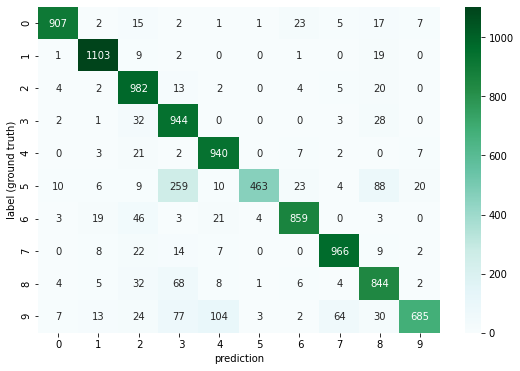

In [ ]:
test_load_all = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False)


correct = 0
for X_test, y_test in test_load_all:
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    adversary = LinfPGDAttack(model,loss_fn=nn.CrossEntropyLoss(),eps=0.2,clip_min=0.0,clip_max=1.0,targeted=True) ##attack
    target = (torch.ones_like(y_test)*2).to(device)    #target
    X_adv= adversary.perturb(X_test,target)  #adversarial example
    gauss = kornia.filters.GaussianBlur2d((3,3), (10.5,10.5)) #blurring
    X_adv: torch.tensor = gauss(X_adv) #blurred image
    y_val = model(X_adv)
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test).sum()
        
print(f'Test accuracy Basic: {correct.item()}/{len(test_dataset)} = {correct.item()*100/(len(test_dataset)):7.3f}%')

class_names = ['0', '1', ' 2', '  3', ' 4', ' 5', ' 6', '7', '8', '9']
arr = confusion_matrix(y_test.view(-1).cpu(), predicted.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)


plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()